### This notebook contains the code for the Adversarial Region Plots used as the intuition for the cGAN framework.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import DatasetGeneratorsVF as DG
from sklearn.svm import SVC
from matplotlib import cm
import FrameworkFunctionsVF as FF

In [8]:
# Reproducibility Parameters
RANDOM_STATE = 1
percentage_points = 0.01

# Visualisation parameters
plt.style.use('seaborn')
FONTSIZE = 20

# Dataset parameters

f1_b = [-8,8]
f2_b = [-8,8]

centres = np.array([[2.0,0],\
    [-2.0,0]]) 
covs = np.array([[[1,0.5],[0.5,1.5]],\
    [[1,-0.5],[-0.5,1.5]]]) 

num_samples = np.array([1000,1000]) #Choose very large number for more stability
resol = 20

save_path = 'Results/AdversarialRegionsforcGANS/'

# Bias Parameters 
biases = np.linspace(0,360,17)
planeCentre = np.array([2.0,0]) 
prob = 0.0



In [9]:
# Finding regions for different biases
# Generate unbiased dataset
DSUnbiased1, DSUnbiased0 = DG.GenerateMultiVarGaussians(centres,covs,num_samples, RANDOM_STATE)
UnbiasedX = np.vstack((DSUnbiased1,DSUnbiased0))
UnbiasedY = np.hstack((np.ones((np.shape(DSUnbiased1)[0])),np.zeros((np.shape(DSUnbiased0)[0]))))

for i,b in enumerate(biases):

    print(i, end = ",")

    alpha = -np.radians(b)

    # Generate bias in dataset
    DSBias1, plane = DG.KathBiasPlane2D(DSUnbiased1, alpha, planeCentre, prob, RANDOM_STATE)

    BiasedX = np.vstack((DSBias1,DSUnbiased0))
    BiasedY = np.hstack((np.ones((np.shape(DSBias1)[0])),np.zeros((np.shape(DSUnbiased0)[0]))))

    NUM_POINTS = int(np.round(len(BiasedY)*percentage_points))
    print(NUM_POINTS)

    # Train
    clfBias = SVC(kernel = 'linear', random_state = RANDOM_STATE)
    clfBias.fit(BiasedX,BiasedY)
    clfBiasAcc = clfBias.score(UnbiasedX,UnbiasedY)

    # Poisoning Attack
    Loss1, Loss0, LossMax, LossMaxLabel, F1_pois, F2_pois = FF.ALPADRUnRegMorePoints(BiasedX, BiasedY, clfBias, f1_b, f2_b, resol, random_state = RANDOM_STATE, num_points=NUM_POINTS)

    np.savetxt(save_path + 'Loss1/Loss1_{:.2f}d.csv'.format(b), Loss1, delimiter=',')  
    np.savetxt(save_path + 'Loss0/Loss0_{:.2f}d.csv'.format(b), Loss0, delimiter=',')  
    np.savetxt(save_path + 'LossMax/LossMax_{:.2f}d.csv'.format(b), LossMax, delimiter=',')
    np.savetxt(save_path + 'Grids/F1_pois_{:.2f}d.csv'.format(b), F1_pois, delimiter=',')
    np.savetxt(save_path + 'Grids/F2_pois_{:.2f}d.csv'.format(b), F2_pois, delimiter=',')
    np.savetxt(save_path + 'Datasets/BiasedX_{:.2f}d.csv'.format(b), BiasedX, delimiter=',')
    np.savetxt(save_path + 'Datasets/BiasedY_{:.2f}d.csv'.format(b), BiasedY, delimiter=',')

    

0,15
1,15
2,15
3,15
4,15
5,15
6,15
7,15
8,15
9,15
10,15
11,15
12,15
13,15
14,15
15,15
16,15


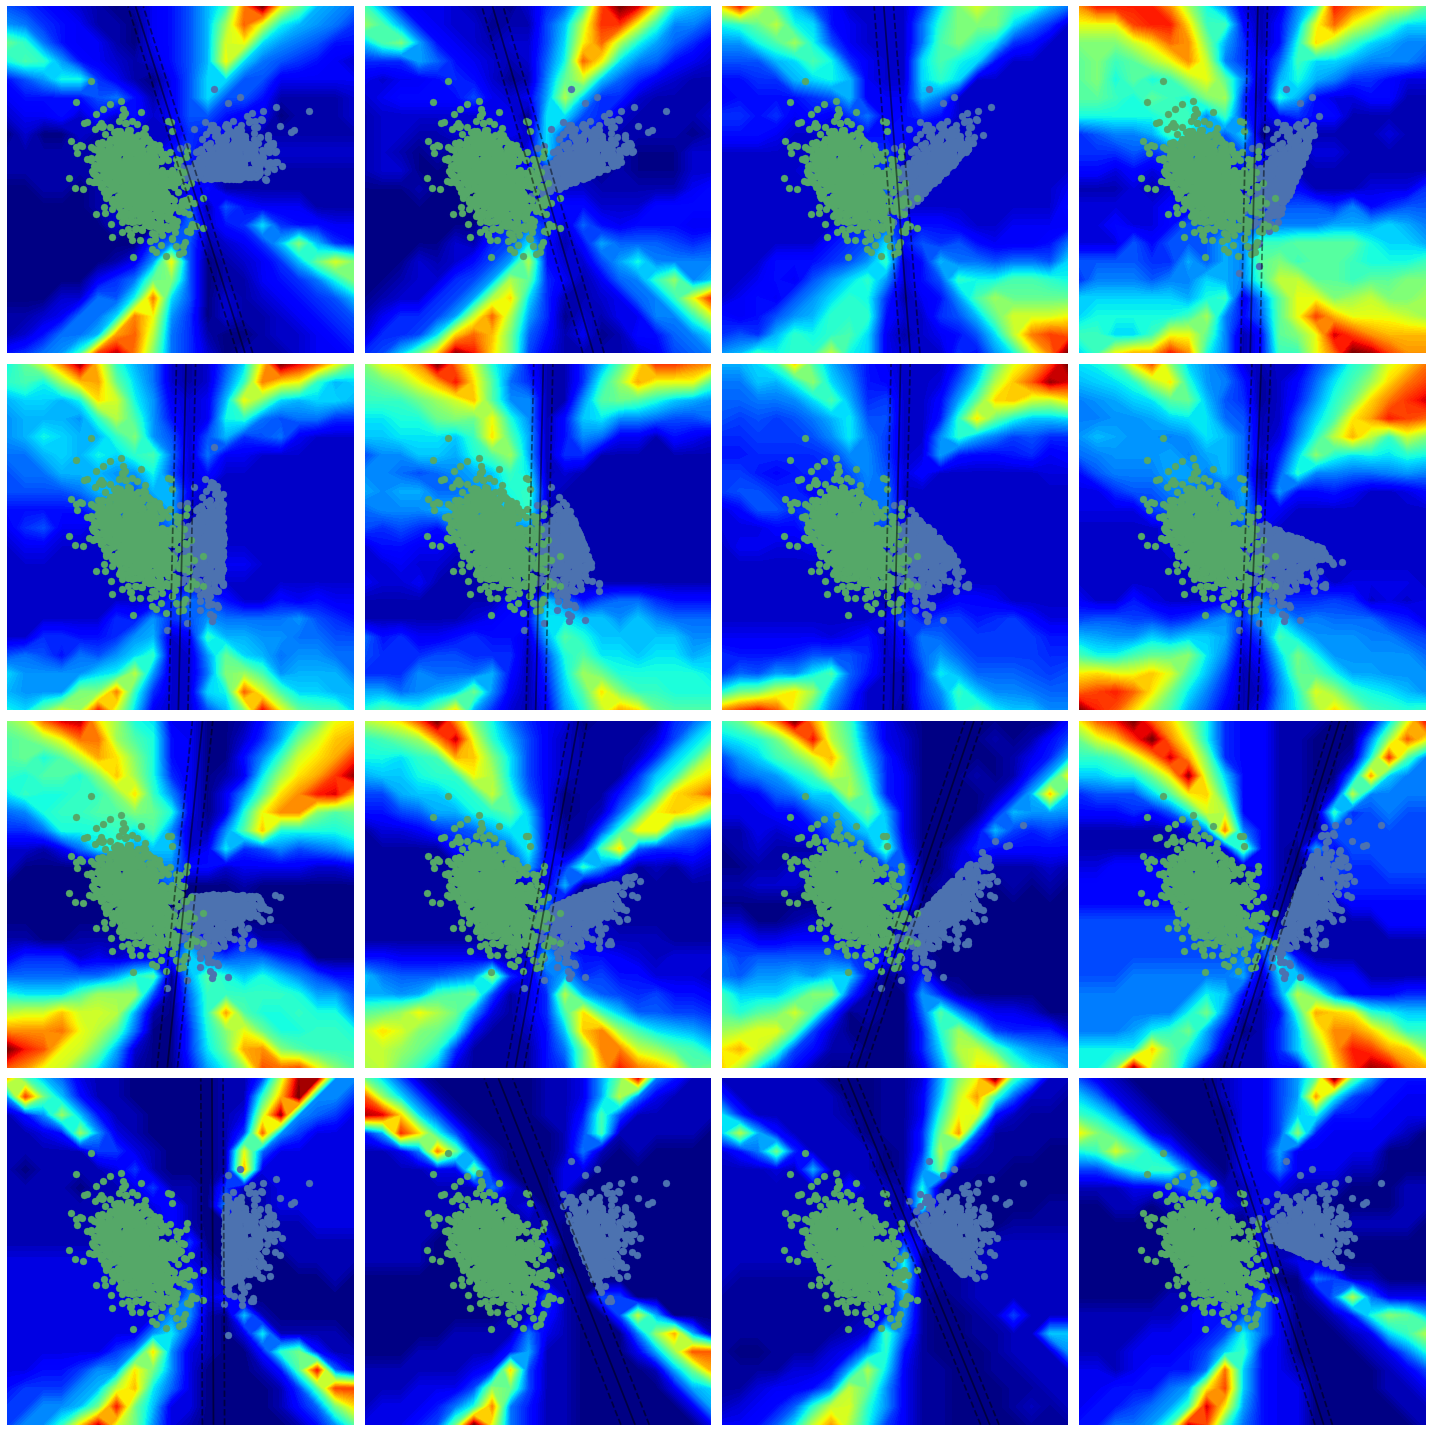

In [15]:
# Plotting the different adversarial regions

import csv

def LoadArray(fileName):
    data = []
    file = open(fileName)
    csvreader = csv.reader(file)
    for row in csvreader:
        data.append([float(i) for i in row])

    return np.array(data)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20,20))
biases = np.linspace(0,360,17)[0:16]

for j,b in enumerate(biases): 

    LossMax = LoadArray(save_path + 'LossMax/LossMax_{:.2f}d.csv'.format(b))
    F1_pois = LoadArray(save_path + 'Grids/F1_pois_{:.2f}d.csv'.format(b))
    F2_pois = LoadArray(save_path + 'Grids/F2_pois_{:.2f}d.csv'.format(b))
    BiasedX = LoadArray(save_path + 'Datasets/BiasedX_{:.2f}d.csv'.format(b))
    BiasedY = LoadArray(save_path + 'Datasets/BiasedY_{:.2f}d.csv'.format(b)).ravel()

    # Train
    clfBias = SVC(kernel = 'linear', random_state = 1)
    clfBias.fit(BiasedX,BiasedY)
    clfBiasAcc = clfBias.score(UnbiasedX,UnbiasedY)

    # Visualise
    ## Plotting Decision Boundary ##
    # https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
    # create grid to evaluate model
    x = np.linspace(f1_b[0], f1_b[1], 100)
    y = np.linspace(f2_b[0], f2_b[1], 100)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = clfBias.decision_function(xy).reshape(X.shape)

    axs[int(j/4),j%4].contour(X, Y, P, colors='k',
        levels=[-1, 0, 1], alpha=0.5,
        linestyles=['--', '-', '--'])
    cs = axs[int(j/4),j%4].contourf(F1_pois,F2_pois,LossMax, cmap = cm.jet, levels = 100, extend = 'max')
    axs[int(j/4),j%4].scatter(BiasedX[BiasedY == 1,0],BiasedX[BiasedY == 1,1], label = "1")
    axs[int(j/4),j%4].scatter(BiasedX[BiasedY == 0,0],BiasedX[BiasedY == 0,1], label = '0')
    # axs[int(j/4),j%4].set_title("Accuracy on unbiased dataset: {:.2%}".format(clfBiasAcc), fontsize = FONTSIZE)
    # axs[int(j/4),j%4].set_xlabel("F1", fontsize = FONTSIZE)
    # axs[int(j/4),j%4].set_ylabel("F2", fontsize = FONTSIZE)
    axs[int(j/4),j%4].axis("off")
    # axs[int(j/4),j%4].tick_params(labelsize=FONTSIZE)
    axs[int(j/4),j%4].set_xlim(f1_b)
    axs[int(j/4),j%4].set_ylim(f2_b)
    
    plt.tight_layout()
    plt.savefig(save_path + 'AdversarialRegionsPlots.svg',format = 'svg')